In [1]:
import os
import re
import math
import glob
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
 

In [ ]:
# Function to sort the files in Conditions folder
# in chronological order
def sort_dirs(path):
    path = os.path.basename(path)
    if path.startswith("."):
        return 0
    # Regex to find the pattern: ([1-9])
    found = re.search(r'\((\d+)\)', path)
    if not found:
        return 0
    return int(found.group(1))

# Function to sort the files in Production folder
# in chronological order
def sort_prod(file):
    if file.startswith("."):
        return 0
    try:
        # Regex to find the pattern: 2022-[0-9][0-9]-[0-9][0-9]
        # Hardcoded to 2022 to keep it simple
        found = re.search(r'2022-\d{2}-\d{2}', file)
        index = found.end()
    except Exception as e:
        print(f"ERR on {file}")
    return int(file[index - 2:file.index(".csv")])
   
# Function to split the time and day values into
# two separate columns for Conditions and Production 
def split_time_day(df):
    df[['time','day']] = (
        df['time_day']
           .str.split('/', expand=True)
           .apply(lambda col: col.str.strip())
    )
    df['day'] = df['day'].astype(int)
    df.drop('time_day', axis=1, inplace=True)
    return df

# Function to parse the Conditions folder for a given month
# Returns a dataframe that combines both weather diagrams
def parse_conditions(dir):
    path = os.path.join(os.getcwd(), dir)
    
    # Get diagram 1 data into a dataframe
    full_path = os.path.join(path, "Weather_Diagram_1*")
    diagram_1_data = []
    for file in sorted(glob.glob(full_path), key=sort_dirs):
        if file.startswith("."):
            continue
        data = pd.read_csv(file, sep=";",skiprows=1,header=None,
                           names=["time_day","ambient","module_temp","wind"])
        diagram_1_data.append(data)
    df1 = pd.concat(diagram_1_data, ignore_index=True)
    df1 = split_time_day(df1)
    
    # Get diagram 2 data into a dataframe
    full_path = os.path.join(path, "Weather_Diagram_2*")
    diagram_2_data = []
    for file in sorted(glob.glob(full_path), key=sort_dirs):
        if file.startswith("."):
            continue
        data = pd.read_csv(file, sep=";",skiprows=1,header=None,
                           names=["time_day","insolation"])
        diagram_2_data.append(data)
    df2 = pd.concat(diagram_2_data, ignore_index=True)
    df2 = split_time_day(df2)
    
    # Merge into one dataframe
    combined_df = pd.merge(df1,df2,on=['day','time'])
    return combined_df

# Function to parse the Production folder for a given month
# Returns a dataframe that contains the power output data
def parse_production(dir):
    path = os.path.join(os.getcwd(), dir)
    df = []
    for file in sorted(os.listdir(path),key=sort_prod):
        if file.startswith("."):
            continue
        full_path = f"{path}/{file}"
        data = pd.read_csv(full_path, sep=";",skiprows=1,header=None, 
                           names=["time","power"])
        day = int(file.split("-")[-1].split(".")[0])
        data['day'] = day
        df.append(data)
    df = pd.concat(df, ignore_index=True)
    df['time'] = df['time'].str.strip()
    df['power'] = pd.to_numeric(df['power'], errors='coerce')
    return df
    
# Load data
data_dir = "PVSystem/"

# Arrays for data
all_inputs = []
all_outputs = []
by_month_data = dict()

# Loop through each month
for dir in sorted(os.listdir(data_dir)):
    full_path = os.path.join(data_dir, dir)
    if not os.path.isdir(full_path) or dir.startswith("."):
        continue
    
    # Parse each month directory and store the result
    cond_df = parse_conditions(full_path + '/Conditions')
    prod_df = parse_production(full_path + '/Production')
    all_inputs.append(cond_df.assign(month=dir))
    all_outputs.append(prod_df.assign(month=dir))
    
    # Separate the data by month for graphs and mode evaluation later
    by_month_data[dir] = dict()
    by_month_data[dir]['cond'] = []
    by_month_data[dir]['prod'] = []
    by_month_data[dir]['cond'].append(cond_df.assign(month=dir))
    by_month_data[dir]['prod'].append(prod_df.assign(month=dir))

# Combines data into one dataframe
all_inputs = pd.concat(all_inputs, ignore_index=True)
all_outputs = pd.concat(all_outputs, ignore_index=True)
all_data = pd.merge(
    all_inputs,
    all_outputs,
    on=['month','day','time'],
    how='left'
)


In [ ]:
# Create and train model

# Get the hour from the time column
all_data['hour'] = all_data['time'].str.extract(r'(\d+):').astype(int)
# Features for module temp prediction
init_features = ['ambient', 'wind', 'insolation', 'month', 'day', 'hour']
# init + moddule temp = features for power prediction
mod_temp_feature = ['module_temp']
target = ['power']

# Drop all N/A values and have data only contain necessary data from selected features
data = all_data[init_features + mod_temp_feature + target].dropna().reset_index(drop=True)

# Scaler for each feature in data
init_scaler = MinMaxScaler()
mod_temp_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the data
X_scaled = init_scaler.fit_transform(data[init_features])
mod_temp_scaled = mod_temp_scaler.fit_transform(data[mod_temp_feature])
Y_scaled = target_scaler.fit_transform(data[target])

# Training and validation data arrays
X_train, X_val = [], []
mod_temp_train, mod_temp_val = [], []
Y_train, Y_val = [], []

# Create LSTM sequences
SEQ_LEN = 12
def create_sequences(month_df):
    X  = init_scaler.transform(month_df[init_features])
    mod_temp  = mod_temp_scaler.transform(month_df[mod_temp_feature])
    Y  = target_scaler.transform(month_df[target])
    Xs, Y1s, Y2s = [], [], []
    for i in range(len(X) - SEQ_LEN):
        Xs.append(X[i:i+SEQ_LEN])
        Y1s.append(mod_temp[i+SEQ_LEN])
        Y2s.append(Y[i+SEQ_LEN])
    return np.array(Xs), np.array(Y1s), np.array(Y2s)

# Loop through each month and create the training and validation data
# This is to ensure that the model is trained on the data in 
# chronological order
for month in sorted(by_month_data):
    cond_df = by_month_data[month]["cond"][0]
    prod_df = by_month_data[month]["prod"][0]
    temp = cond_df.merge(prod_df, on=["month", "day", "time"], how="left")
    temp["hour"] = temp["time"].str.extract(r'(\d+):').astype(int)
    
    month_df = temp[init_features + mod_temp_feature + target].dropna().reset_index(drop=True)
    
    # 80/20 split for the training and validation data
    x, mod_temp, y = create_sequences(month_df)
    cutoff = int(0.8 * len(x))
    
    X_train.append(x[:cutoff])
    X_val.append(x[cutoff:])
    mod_temp_train.append(mod_temp[:cutoff])
    mod_temp_val.append(mod_temp[cutoff:])
    Y_train.append(y[:cutoff])
    Y_val.append(y[cutoff:])

# Combines all month inputs into one input array
X_train = np.concatenate(X_train)
X_val = np.concatenate(X_val)
mod_temp_train = np.concatenate(mod_temp_train)
mod_temp_val = np.concatenate(mod_temp_val)
Y_train = np.concatenate(Y_train)
Y_val = np.concatenate(Y_val)
print("Train shape :", X_train.shape, Y_train.shape)
print("Val   shape :", X_val.shape,   Y_val.shape)

Train shape : (3680, 12, 6) (3680, 1)
Val   shape : (926, 12, 6) (926, 1)


In [ ]:
tf.random.set_seed(42)

# Define model architecture
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Layers that predict are used before mod_temp and power predictions
shared_layers = LSTM(64, recurrent_activation='sigmoid',activation='tanh',return_sequences=True)(input_layer)
shared_layers = Dropout(0.2)(shared_layers)
shared_layers = LSTM(32)(shared_layers)

# Layers to predict mod_temp
mod_temp_layers = Dense(16, activation='relu')(shared_layers)
mod_temp_layers = Dense(1, name="module_temp")(mod_temp_layers)

# Layers to predict power
power_layers = Concatenate()([shared_layers, mod_temp_layers])
power_layers = Dense(32, activation='relu')(power_layers)
power_layers = Dense(1, name="power")(power_layers)

# Create model, module temp error is not as important at power
# error, so give less weight to module_temp
model = Model(inputs=input_layer, outputs=[mod_temp_layers, power_layers])
model.compile(
    optimizer="adam",
    loss={"module_temp": "mse", "power": "mse"},
    loss_weights={"module_temp": 0.3, "power": 1.0},
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     18,176 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ module_temp (Dense) │ (None, 1)         │         17 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ module_temp[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power (Dense)       │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,258 (126.01 KB)

 Trainable params: 32,258 (126.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks and train the model
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = EarlyStopping(patience=50, restore_best_weights=True)
if os.path.isfile("./power_prediction.keras"):
    history = model.fit(
        X_train,
        {"module_temp": mod_temp_train, "power": Y_train},
        validation_data=(X_val,
                        {"module_temp": mod_temp_val, "power": Y_val}),
        epochs=500,
        batch_size=64,
        callbacks=[tensorboard_callback, earlystopping_callback],
        verbose=1,
    )

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0946 - module_temp_loss: 0.0592 - power_loss: 0.0768 - val_loss: 0.0609 - val_module_temp_loss: 0.0164 - val_power_loss: 0.0554
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0498 - module_temp_loss: 0.0096 - power_loss: 0.0469 - val_loss: 0.0499 - val_module_temp_loss: 0.0093 - val_power_loss: 0.0463
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319 - module_temp_loss: 0.0054 - power_loss: 0.0303 - val_loss: 0.0359 - val_module_temp_loss: 0.0075 - val_power_loss: 0.0332
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0255 - module_temp_loss: 0.0042 - power_loss: 0.0242 - val_loss: 0.0309 - val_module_temp_loss: 0.0066 - val_power_loss: 0.0288
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0238 - module_temp_loss: 0.0037 - power_loss: 0.0227 - val_loss: 0.0290 - val_module_temp_loss: 0.0067 - val_power_loss: 0.0268
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - l

In [ ]:
# Do a final validation of the model and save trained model
val_loss, val_mod_temp_loss, val_power_loss = model.evaluate(
    X_val,
    {"module_temp": mod_temp_val, "power": Y_val},
    verbose=1,
)

print(f"\nTotal val loss : {val_loss:.4f}")
print(f"Mod_temp val MSE : {val_mod_temp_loss:.4f}")
print(f"Power val MSE : {val_power_loss:.4f}")
model.save("power_prediction.keras")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - module_temp_loss: 0.0034 - power_loss: 0.0107 

Total val loss : 0.0123
Mod_temp val MSE : 0.0037
Power val MSE : 0.0112


In [ ]:
# Print average accuracy percentage across the entire
# (scaled) validation set
pred_power_scaled = model.predict(X_val, verbose=0)[1]
err  = (1 - np.abs(pred_power_scaled - Y_val)) * 100
avg_acc = err.mean()

print(f"Avg power accuracy (scaled): {avg_acc:.2f}%")

Avg power accuracy (scaled): 92.80%


Jan accuracy (scaled): 94.34%
Jan real accuracy (≤100W error): 30.79%
Feb accuracy (scaled): 94.16%
Feb real accuracy (≤100W error): 31.22%
Mar accuracy (scaled): 92.07%
Mar real accuracy (≤100W error): 30.20%
Apr accuracy (scaled): 90.18%
Apr real accuracy (≤100W error): 23.88%
May accuracy (scaled): 91.72%
May real accuracy (≤100W error): 25.00%
Jun accuracy (scaled): 93.12%
Jun real accuracy (≤100W error): 30.34%
Jul accuracy (scaled): 94.24%
Jul real accuracy (≤100W error): 29.38%
Aug accuracy (scaled): 94.54%
Aug real accuracy (≤100W error): 33.08%
Sep accuracy (scaled): 94.01%
Sep real accuracy (≤100W error): 35.23%
Oct accuracy (scaled): 94.70%
Oct real accuracy (≤100W error): 35.38%
Nov accuracy (scaled): 94.44%
Nov real accuracy (≤100W error): 34.25%


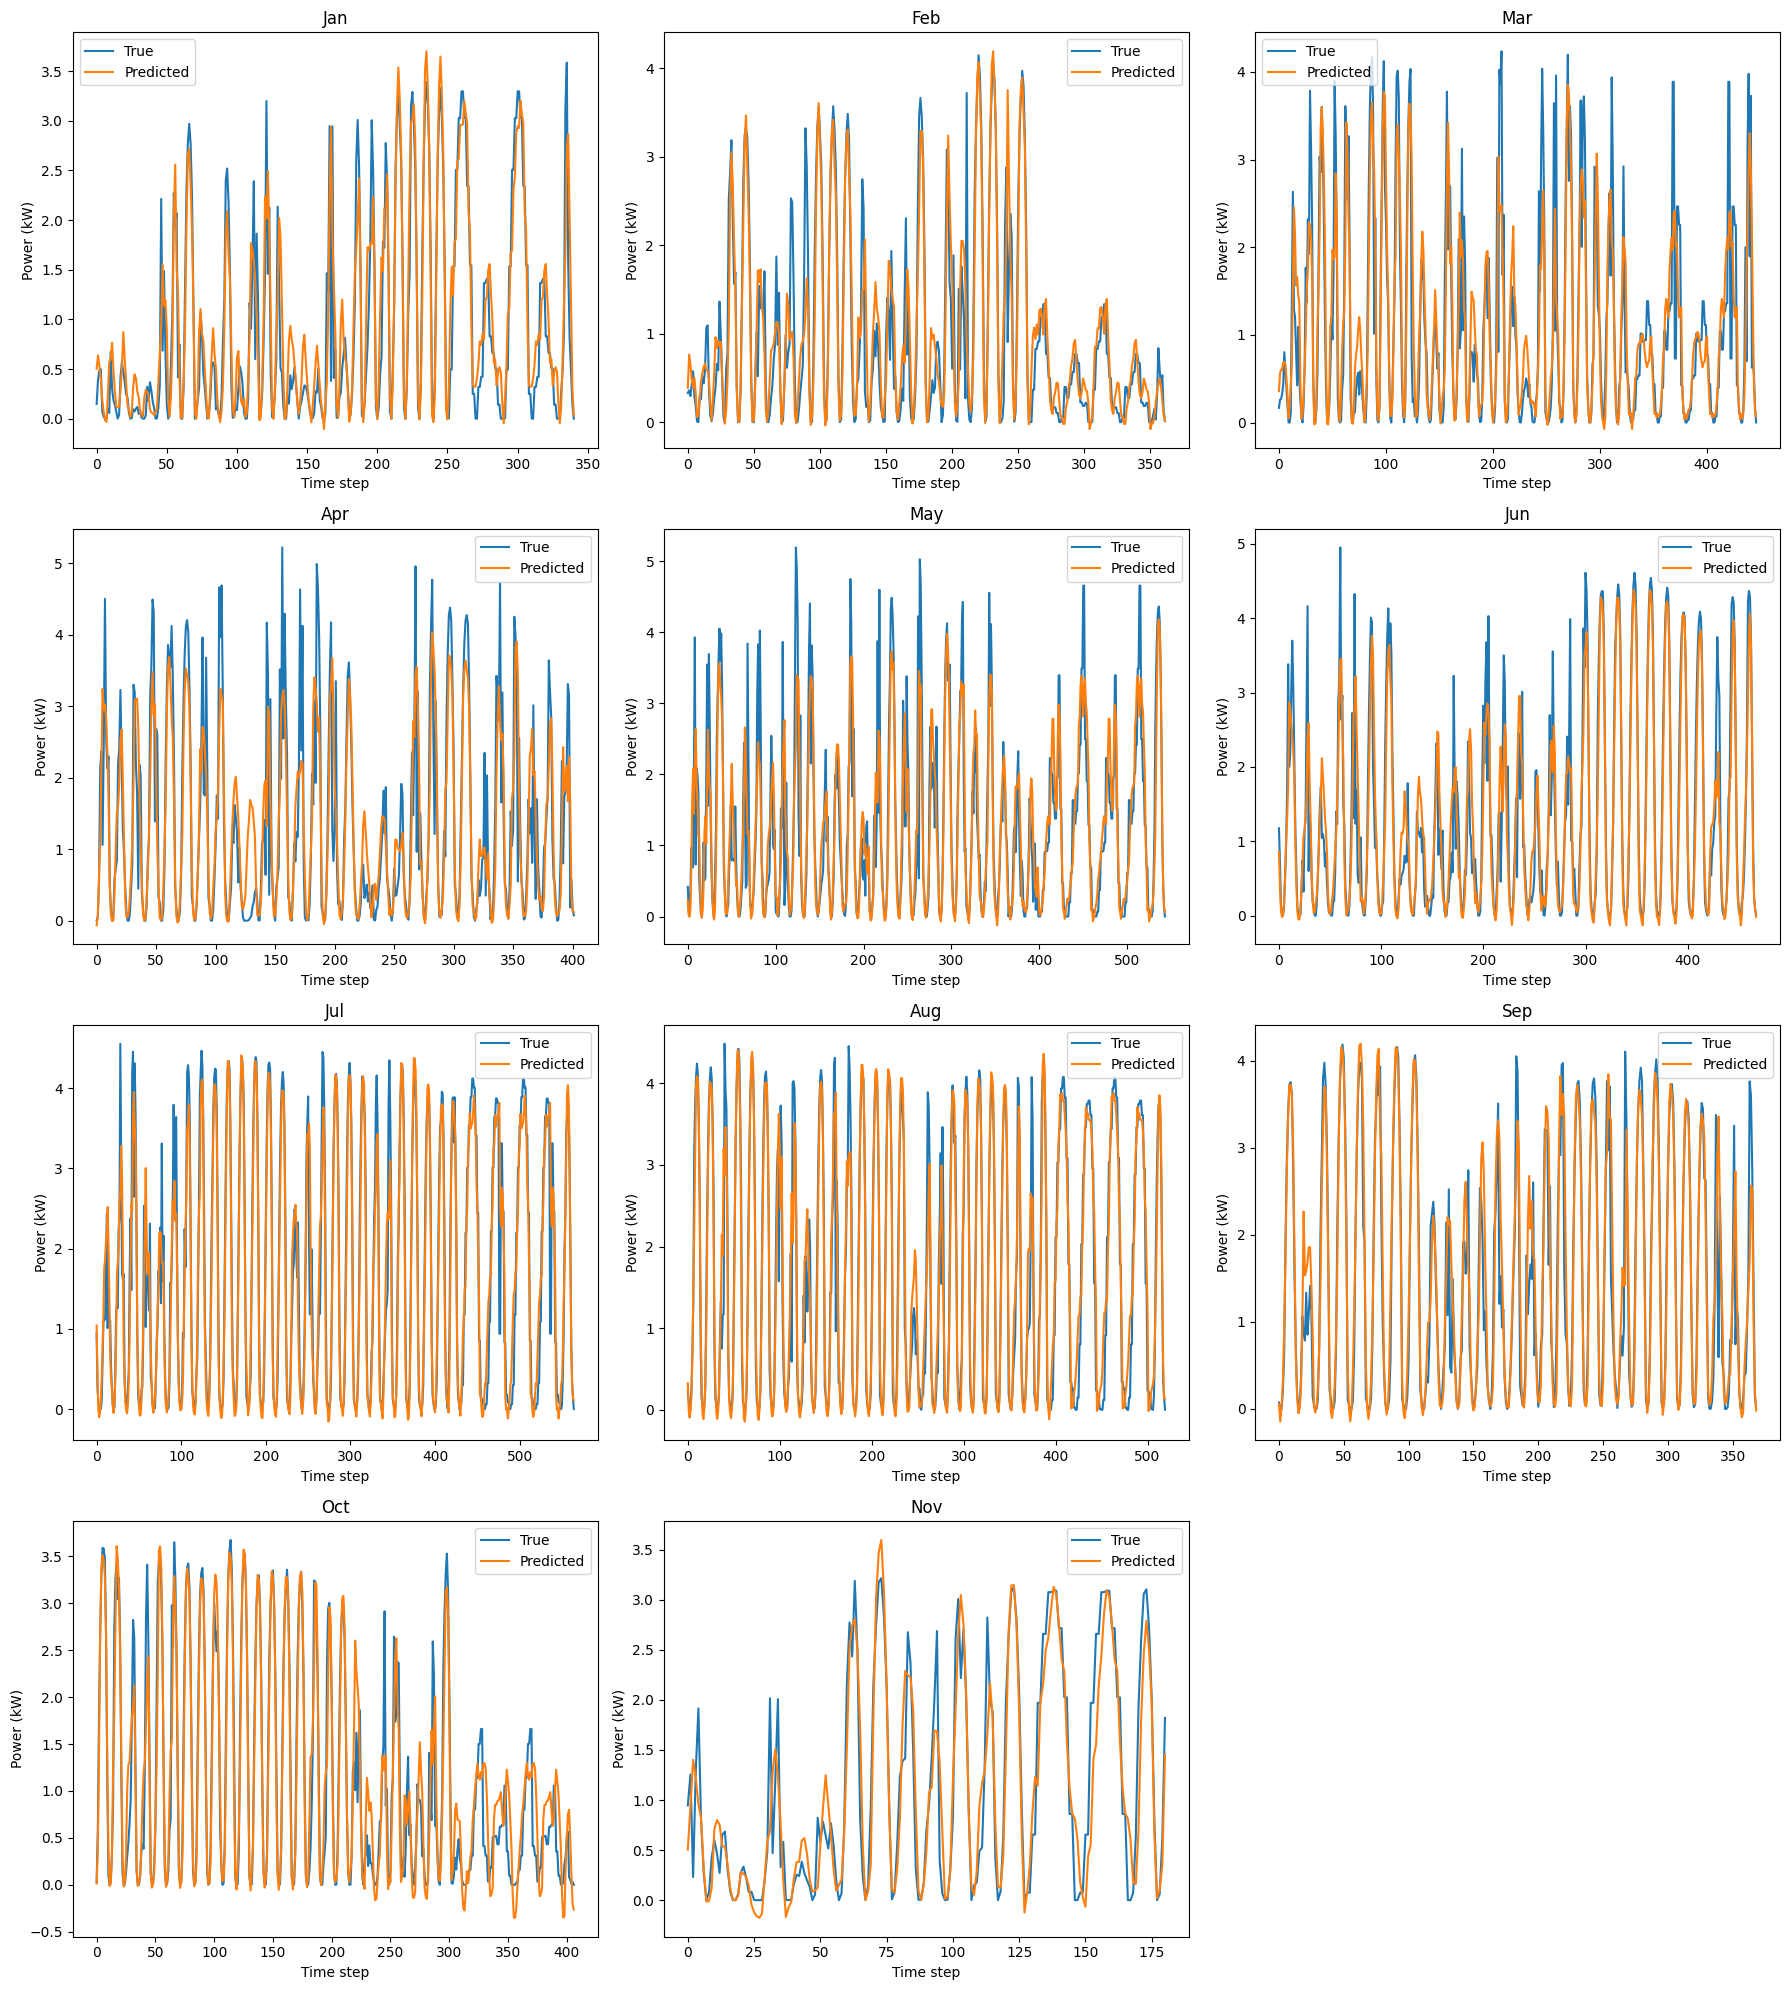

In [ ]:

# Convert directory names to actual month names
month_name = {
    "01": "Jan","02": "Feb","03": "Mar","04": "Apr",
    "05": "May","06": "Jun","07": "Jul","08": "Aug",
    "09": "Sep","10": "Oct","11": "Nov","12": "Dec"
}

# Sequences for validation and graphs
def make_sequences(X, seq_len=SEQ_LEN):
    return np.array([X[i:i+seq_len] for i in range(len(X)-seq_len)])

# Define subplots
cols = 3
rows = math.ceil(len(by_month_data) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, 5*rows))
plt.subplots_adjust(hspace=0.6)
axs = axs.flatten()

idx = 0
# Loop through each month's data
for key in sorted(by_month_data):
    cond_df = by_month_data[key]["cond"][0]
    prod_df = by_month_data[key]["prod"][0]
    month_df = cond_df.merge(prod_df, on=["month","day","time"], how="left")
    month_df["hour"]   = month_df["time"].str.extract(r'(\d+):').astype(int)

    # Make sure the same scalers are used here
    df = month_df[init_features + ["power"]].dropna().reset_index(drop=True)
    X_scaled = init_scaler.transform(df[init_features])
    y_scaled = target_scaler.transform(df[["power"]])
    X_seq = make_sequences(X_scaled)
    y_seq = y_scaled[SEQ_LEN:]

    # Predict on the entire dataset for the month and print
    # (scaled) accuracy
    y_pred_scaled = model.predict(X_seq, verbose=0)[1]
    acc_vec = (1 - np.abs(y_pred_scaled - y_seq)) * 100
    month_acc = acc_vec.mean()
    print(f"{month_name[key]} accuracy (scaled): {month_acc:.2f}%")
    
    # Convert actual and predicted values back to kW
    y_pred_kw = target_scaler.inverse_transform(y_pred_scaled).flatten()
    y_true_kw = target_scaler.inverse_transform(y_seq).flatten()

    # This metric is for printing the accuracy over the unscaled values
    diff = np.abs(y_pred_kw - y_true_kw)
    correct_preds = diff <= 0.1
    # correct_preds = diff <= 2.93 # Numbers that gives 100% acc for all months
    acc_real = correct_preds.mean() * 100

    # print(f"{month_name[key]} real accuracy (≤100W error): {acc_real:.2f}%")
    
    # Plot
    ax = axs[idx]; idx += 1
    ax.plot(y_true_kw, label="True")
    ax.plot(y_pred_kw, label="Predicted")
    ax.set_title(f"{month_name.get(key, key)}")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Power (kW)")
    ax.legend()

# Turn off unused subplots
for j in range(idx, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()